In [12]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 José David González
#
# This code is provided for educational and research purposes only.
# Unauthorized copying, distribution, or modification of this file,
# via any medium, is strictly prohibited without the express permission
# of the copyright holder.
# -----------------------------------------------------------------------------

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay,  balanced_accuracy_score)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [14]:
# Load dataset
df_os = pd.read_csv('datasets/openstack_metrics.csv') # the OS df
df_qt = pd.read_csv('datasets/qt_metrics.csv') # the QT df

bugrows_OS = len(df_os[df_os["bugcount"]>0])
bugrows_QT = len(df_os[df_os["bugcount"]>0])

concat_df = pd.concat([df_os, df_qt])
bugrows_ALL = len(concat_df[concat_df["bugcount"]>=0])

print("Rows in    OSdf:", bugrows_OS ,"/",len(df_os),"=", bugrows_OS/len(df_os), "   QTdf:", bugrows_QT ,"/", len(df_qt), "=",bugrows_QT/len(df_qt) )
print("Rows in contact:", bugrows_ALL ,"/",len(concat_df),"=", bugrows_ALL/len(concat_df))


Rows in    OSdf: 1968 / 26855 = 0.0732824427480916    QTdf: 1968 / 32155 = 0.06120354532732079
Rows in contact: 6262 / 59010 = 0.10611760718522284


In [15]:
concat_df[concat_df["bugcount"]>=0]

,commit_id,author_date,bugcount,fixcount,la,ld,nf,nd,ns,ent,...,oexp,arexp,rrexp,orexp,asexp,rsexp,osexp,asawr,rsawr,osawr
9,001407b969bc12d48bd7f10960f84f519bb19111,1278972225,1.0,NaN,22435,0,104,22,5,0.816511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,001d36c97eac77410f7dd32290d2142abfb19fa0,1392721937,0.0,NaN,12,6,2,2,1,0.309543,...,2599.0,834.0,1211.0,1873.0,1087.0,1361.0,2241.0,0.147545,0.184703,0.304041
19,002ce47d757461546c24a4e8ba909fca42c38997,1405937783,2.0,NaN,304,16,12,2,1,0.803639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,002d711fb7f16a6d5c7977e82e30837287b553b8,1322491078,0.0,NaN,272,276,43,12,1,0.931290,...,231.0,83.0,184.0,231.0,16.0,88.0,88.0,0.173469,0.908163,0.908163
23,0043044f2e8ee3de8a9995bdbf51aad77f1a3fa9,1373357890,3.0,NaN,580,283,8,5,1,0.849502,...,687.0,5.0,662.0,664.0,2.0,42.0,43.0,0.060000,0.860000,0.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32079,ff53b1dcec761861f76c7528aafd42c9ce843d56,1307435603,1.0,NaN,149,12,8,1,1,0.784228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32081,ff55f825234dc7ba7fa1436abebd59f2c0f5e5c9,1336133683,1.0,NaN,88,112,11,2,2,0.715993,...,426.0,287.0,426.0,426.0,285.0,412.0,412.0,0.033584,0.048497,0.048497
32103,ff8362d65e8d32c2286cd3f72ab2aa85ad97b6e4,1358202312,1.0,NaN,20,6,1,1,1,0.000000,...,1988.0,287.0,1829.0,1829.0,150.0,605.0,605.0,0.031121,0.124897,0.124897
32139,ffdbf216dc80b3d781307bb6b4b7150281c874a3,1332832820,1.0,NaN,8,5,2,2,1,0.961237,...,205.0,194.0,205.0,205.0,149.0,156.0,156.0,0.025240,0.026418,0.026418


In [16]:
# I will concat both files and use them for split training and evaluation

input_df = concat_df[concat_df["bugcount"]>=0].copy() #drop all rows without bugcount (Those will be useless for training)


input_df["buggy"]=(input_df['bugcount'] >= 1).astype(int) #define buggy when the bugcount is >0
input_df = input_df.drop(['bugcount','commit_id','author_date','fixcount','revd', 'self' ,'age'], axis=1) # drop irrelevant columns


print(len(input_df[input_df["buggy"]==1]),len(input_df) )



4233 6262


In [17]:
X = input_df.drop('buggy', axis=1)
y = input_df['buggy']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=33
)

In [18]:
#pipeline definition
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ])


# the 3 classifiers I will use to compare:

classifiers = {
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=33, class_weight="balanced_subsample"),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=33, class_weight="balanced"),
    "Bagging Classifier": BaggingClassifier(n_estimators=10, random_state=33)
}


In [19]:
# Training and evaluation

results = {}

for idx, (name, clf) in enumerate(classifiers.items()):
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]


    # feature importance
    feature_importance = None
    try:
        # For BaggingClassifier, get from base_estimator_ if possible
        if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
            feature_importance = pipeline.named_steps['classifier'].feature_importances_
        elif hasattr(pipeline.named_steps['classifier'], 'estimators_'):
            # If using Bagging, average importances from base estimators (if available)
            importances = []
            for est in pipeline.named_steps['classifier'].estimators_:
                if hasattr(est, 'feature_importances_'):
                    importances.append(est.feature_importances_)
            if importances:
                feature_importance = np.mean(importances, axis=0)
    except Exception as e:
        feature_importance = None

    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred, zero_division=0),
        'recall' : recall_score(y_test, y_pred, zero_division=0),
        'model': pipeline,
        'f1': f1_score(y_test, y_pred),
        'feature_importance': feature_importance,
        'probas': y_proba
    }
    
    


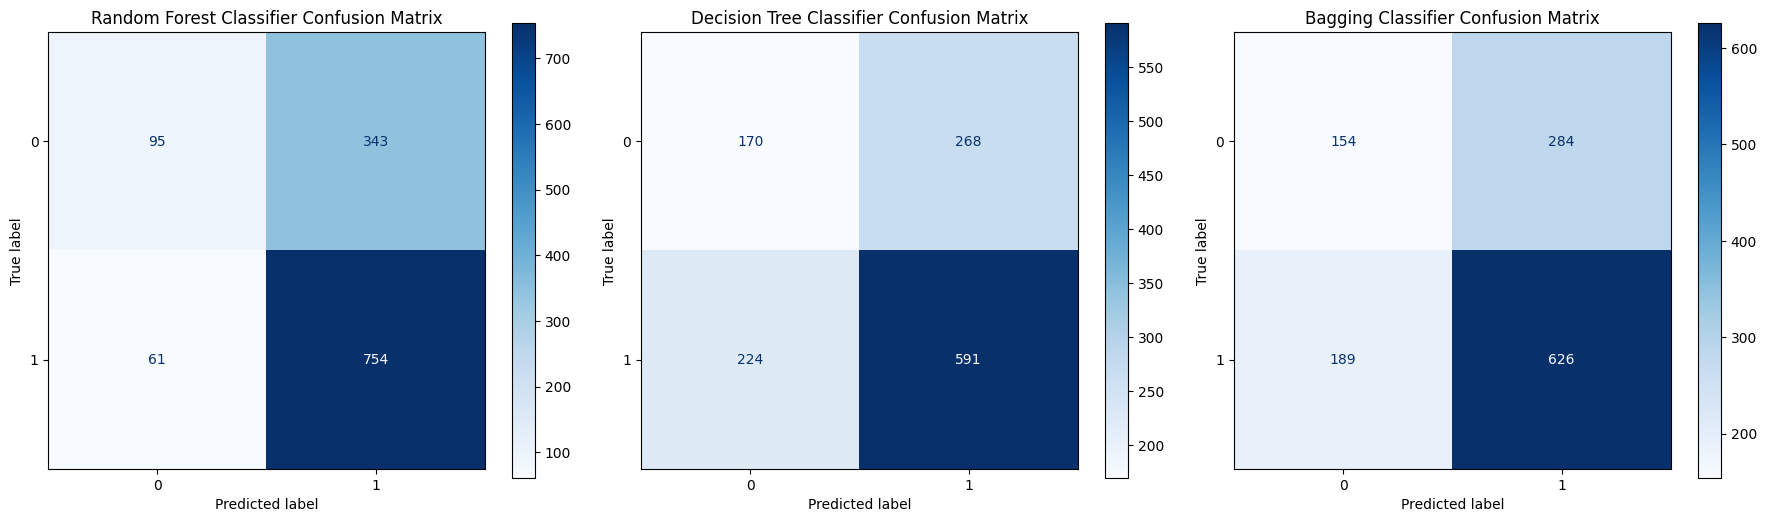

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, res) in enumerate(results.items()):
  # Plot confusion matrix
  ConfusionMatrixDisplay.from_estimator(res['model'], X_test, y_test,  ax=ax[idx], cmap='Blues')
  ax[idx].set_title(f'{name} Confusion Matrix')
  
plt.tight_layout()
plt.show()

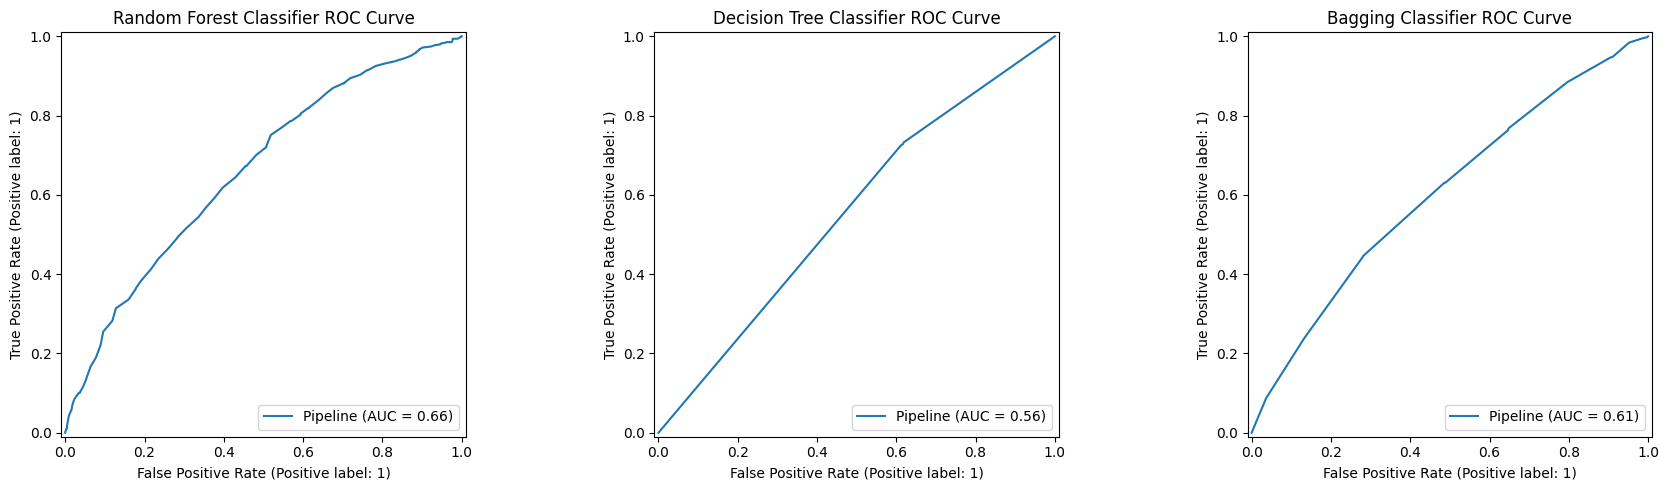

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, res) in enumerate(results.items()):
  # Plot confusion matrix
  RocCurveDisplay.from_estimator(res['model'], X_test, y_test,  ax=ax[idx])
  ax[idx].set_title(f'{name} ROC Curve')
  
plt.tight_layout()
plt.show()

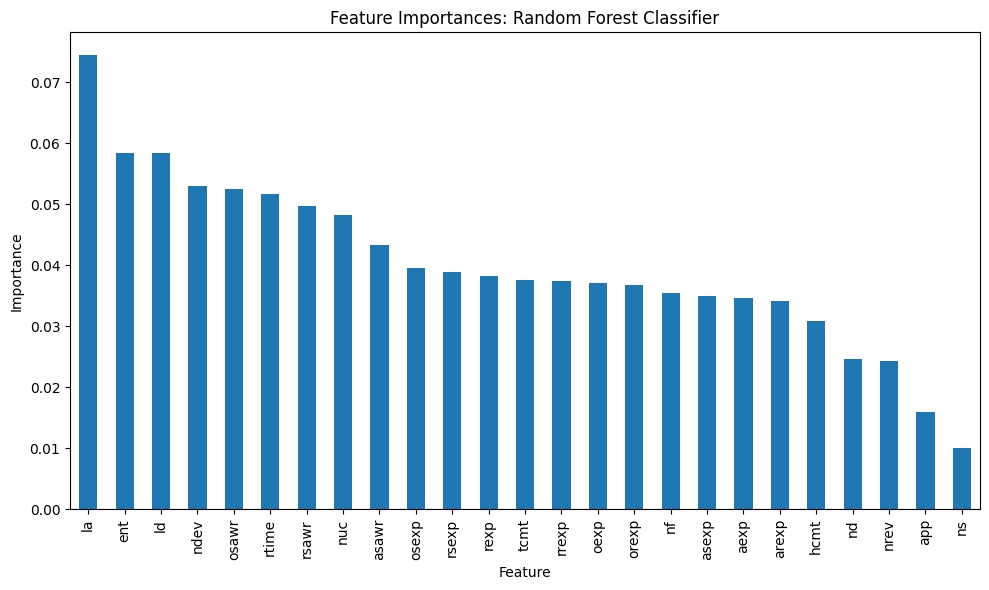

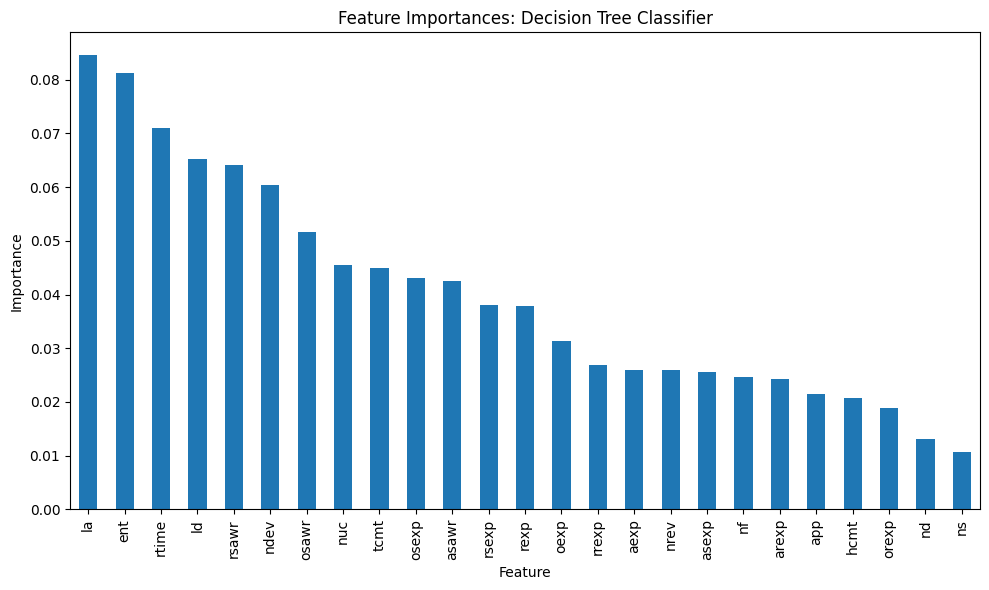

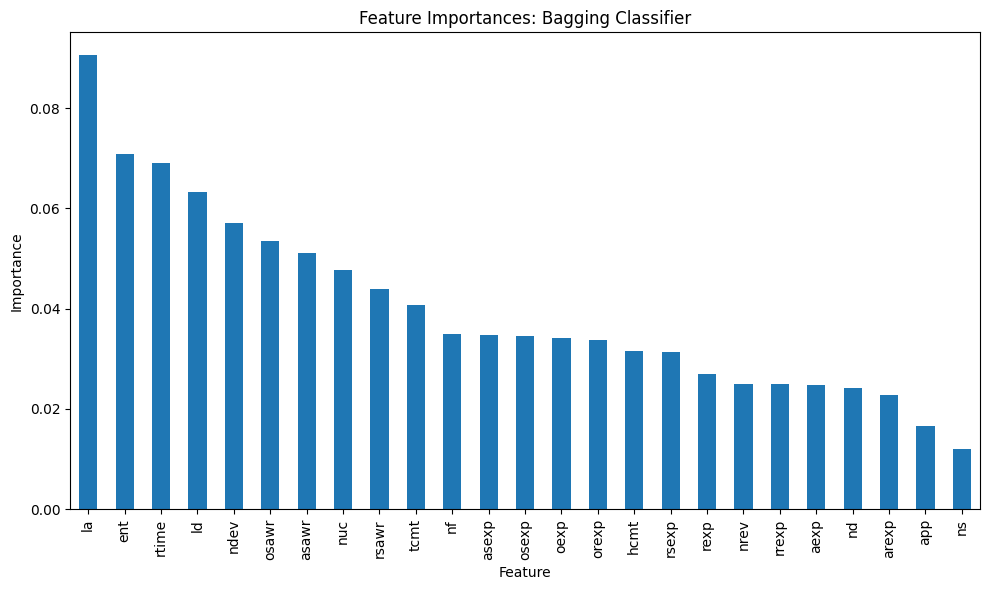

<Figure size 640x480 with 0 Axes>

In [22]:

for idx, (name, res) in enumerate(results.items()):
  if feature_importance is not None:
      plt.figure(figsize=(10, 6))
      feat_imp = pd.Series(res["feature_importance"], index=numeric_features).sort_values(ascending=False)
      feat_imp.plot(kind='bar')
      plt.title(f'Feature Importances: {name}')
      plt.ylabel('Importance')
      plt.xlabel('Feature')
      plt.tight_layout()
      plt.show()
  else:
        print(f"{name}: Feature importance not available for this model.")
  
plt.tight_layout()
plt.show()

In [23]:
# Print metrics
print("Model Performance:")
for name, res in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {res['accuracy']:.3f}")
    print(f"  Balanced Accuracy: {res['balanced_accuracy']:.3f}")
    print(f"  Precision: {res['precision']:.3f}")
    print(f"  Recall: {res['recall']:.3f}")
    print(f"  F1-Score: {res['f1']:.3f}\n")

Model Performance:
Random Forest Classifier:
  Accuracy: 0.678
  Balanced Accuracy: 0.571
  Precision: 0.687
  Recall: 0.925
  F1-Score: 0.789

Decision Tree Classifier:
  Accuracy: 0.607
  Balanced Accuracy: 0.557
  Precision: 0.688
  Recall: 0.725
  F1-Score: 0.706

Bagging Classifier:
  Accuracy: 0.623
  Balanced Accuracy: 0.560
  Precision: 0.688
  Recall: 0.768
  F1-Score: 0.726

